In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
#import pybinding as pb

In [4]:
dry_run = False
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/ '
dest_path = 'DFT_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*wfc*','*.dat'} -e ssh ismhpc:/work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis/ '/home/marco/Data/RICERCA/DFT AND MANY BODY/2D ELECTRONIC AND OPTICAL PROPERTIES/GERMANENE/DFT_analysis'


In [18]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [5]:
# RunRules for m100
nodes = 1
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',
                memory='120GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.QeCalculator(rr)
code.global_options()

# DFT analysis of the Germanene

This notebook contains the DFT analysis of the Germanene performed with QuantumESPRESSO. In particular

* GS is computed directly _at convergence_ using the input file from a previous convergence analysis. 
* We analyze the DFT band structure

## Geometric setup

One possibility is to use symmetric lattice vectors around the $x$ axis, with the lattice the zig-zag along the y axis.

In this case we choose the basis vector as:
$$
a_1 = \frac{a_{lat}}{2}(\sqrt{3},1,0) \, ,\quad a_2 = \frac{a_{lat}}{2}(\sqrt{3},-1,0) \, ,\quad
a_3 = (0,0,c)
$$
Here $a_{lat}$ is the lattice parameter and $c$ determines the spacing between the layers. 

The position of the atoms in the lattice is given by (note that the $A$ and $B$ defined in the
formula do _not_ match the labels in the figure):
$$
A = a_{lat}(0,0,\delta) \, \qquad B = a_{lat}(\frac{1}{2\sqrt{3}},\frac{1}{2},-\delta)
$$
where $\delta$ is the buckling parameter (in units of $a_{lat}$). 

The nearest distance (on the plane) between the atoms is equal to $a = \frac{a_{lat}}{\sqrt{3}}$.

The position of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) are given by:
$$
M = (\frac{1}{\sqrt{3}},0) \, \quad
K = (\frac{1}{\sqrt{3}},\frac{1}{3}) 
$$

In [122]:
alat = 1 # arbitrary units
a1 = alat*np.array([np.sqrt(3)/2,1/2])
a2 = alat*np.array([np.sqrt(3)/2,-1/2])
A = alat*np.array([0,0])
#B = alat*np.array([1/(2*np.sqrt(3)),1/2])
B = alat*np.array([1/np.sqrt(3),0])

In [125]:
lattice = pb.Lattice(a1=a1,a2=a2)
lattice.add_sublattices(('A', A), ('B', B))
t=1
lattice.add_hoppings(([0,  0], 'A', 'B', t),([0, 1], 'B', 'A', t),([1, 0], 'B', 'A', t))
#lattice.add_hoppings(([0,  0], 'A', 'B', t),([0, 1], 'A', 'B', t))#,([1, 0], 'A', 'B', t))

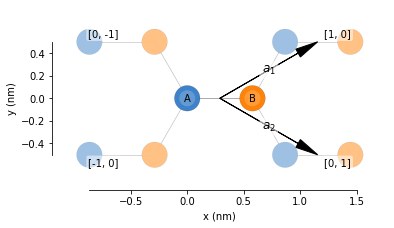

In [126]:
lattice.plot()

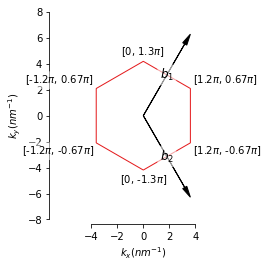

In [127]:
lattice.plot_brillouin_zone()

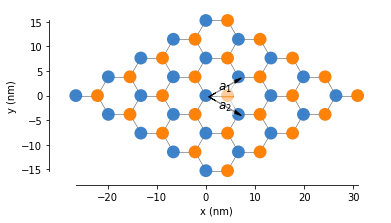

In [49]:
model = pb.Model(lattice,pb.primitive(a1=5, a2=5))
model.plot()
model.lattice.plot_vectors(position=[0.6, -0.25])

Another possibility is to use the geometric setup adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
The atoms are located in 
$$
A = a_{lat}(0,0,\delta) \, \qquad B = a_{lat}(0,\frac{1}{\sqrt{3}},-\delta)
$$
and nearest atomic distance is $a=a_{lat}/\sqrt{3}$ as expected. 
 
In this case the lattice is oriented with the zig-zag along the x axis.

The cartesian component of the reciprocal lattice vectors (in units of $2\pi/a_{alat}$) are given by:

$$
b_1 = (1,\frac{1}{\sqrt{3}}) \, ,\quad b_2 = (0,\frac{2}{\sqrt{3}},0) \, ,\quad
b_3 = (0,0,\frac{a}{c})
$$
The reciprocal vectors have module $2/\sqrt{3}$.

The cartesian coordinates of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) 
can be determined by performing the construction of the Brillouin zone: we find the points on at the half of
the $b_1$ and $b_2$ vectors and build the path moving perpendicularly to the basis vector directions.
The $M$ point (at the middle of the hexagon face) and the $K$ point (the edge point) are given by:
$$
M = (\frac{1}{2},\frac{1}{2\sqrt{3}}) \, \quad
K = (\frac{2}{3},0) 
$$
Moreover we write the coordinates of the symmetry related K' point (which corresponds to another edge of the hexagon)
and M' point (middle point of the top edge of the hexagon): 
$$
K' = (\frac{1}{3},\frac{1}{\sqrt{3}}) \, \quad
M' = (0,\frac{1}{\sqrt{3}}) 
$$
These points, together with $\Gamma$ define the IBZ edges in the representation of QuantumESPRESSO.

In [128]:
alat = 1 # arbitrary units
a1 = alat*np.array([1,0])
a2 = alat*np.array([-1/2,np.sqrt(3)/2])

In [116]:
A = alat*np.array([0,0])
B = alat*np.array([0,1/np.sqrt(3)])

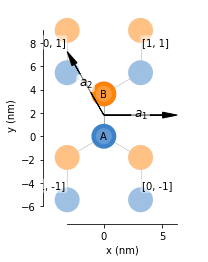

In [119]:
lattice = pb.Lattice(a1=a1,a2=a2)
lattice.add_sublattices(('A', A), ('B', B))
t=1
lattice.add_hoppings(([0,  0], 'A', 'B', t),([0, 1], 'B', 'A', t),([1, 1], 'B', 'A', t))
lattice.plot()

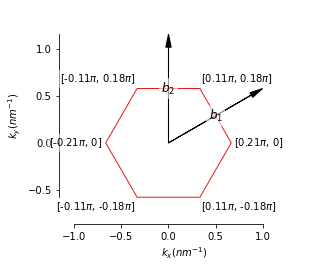

In [120]:
lattice.plot_brillouin_zone()

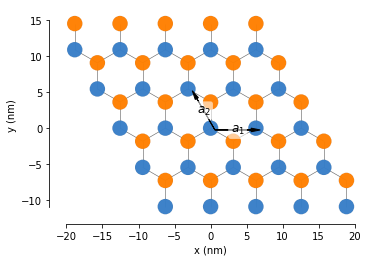

In [121]:
model = pb.Model(lattice,pb.primitive(a1=5, a2=5))
model.plot()
model.lattice.plot_vectors(position=[0.6, -0.25])

## GS Analysis

We use the second geometric setup in which the lattice is defined using the ibrav=4 option of QuantumESPRESSO.

The (inital value) of $a_{lat}$ and the vaccum $c$ parametes are read from the celldm(1) and celldm(3) values of the original input.

The (initial value) buckilng parameter $\delta$ is read from the atomic positions of the original input.

In [4]:
alat = 7.643 # in a.u.
c = 4. # 6. # 8. # in units of alat
delta = 0.083971326 # in units of alat

We set the atomic positions in the basis defined above (in units of alat)

In [5]:
A = np.array([0,0,delta])
B = np.array([0,1/np.sqrt(3),-delta])

We build the basic elements input using the parameters of the original input file.

In [6]:
pseudo = 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF'
pseudo_dir = '../pseudos'
#run_dir = 'DFT_analysis'
run_dir = 'DFT_analysis-vac_4'

In [7]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6) # needed for the Yambo simulations
inp.set_num_bnds(32)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Ge',pseudo_name=pseudo,mass=72.64)
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ge',A],['Ge',B]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=c)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 32,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 7.643,
  'celldm(3)': 4.0},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ge', array([0.        , 0.        , 0.08397133])],
   ['Ge', array([ 0.        ,  0.57735027, -0.08397133])]]},
 'kpoints': {},
 'cell_parameters': {}}

### Convergence procedure on the $k$-points sampling and of energy cutoff of the wave functions

The suggested minimum cutoff for the pseudopotential of the wavefunctions is 38 Ry.

We perform a set of calculations in functions of the number of k-points and of the energy cutoff and we find
the converged values using the total ground state energy and the gap at $K$ as control quantities.

In [9]:
kvalues = [12,15,18]
ecut = [40,45,50,55,60,65,70,75,80,90]

In [12]:
study = D.Dataset(run_dir=run_dir,num_tasks=10)

for k in kvalues:
    for e in ecut:
        idd = {'ecut' : e, 'k' : k}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_kpoints(type='automatic',points=[k,k,1])
        inp.set_energy_cutoff(e)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 10 parallel tasks


In [13]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
Skip the run of Skip the run of 
ecut_40-k_12ecut_45-k_12
Skip the run of ecut_50-k_12
Skip the run of ecut_55-k_12
Skip the run of ecut_60-k_12Skip the run ofSkip the run of
  ecut_65-k_12ecut_70-k_12
Skip the run of
 ecut_75-k_12
Skip the run of ecut_80-k_12
Skip the run of ecut_90-k_12
Task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ended 
 
Run the task [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
Skip the run of Skip the run ofecut_40-k_15
 Skip the run ofecut_45-k_15 
Skip the run ofecut_50-k_15
 ecut_55-k_15
Skip the run of ecut_60-k_15
Skip the run of ecut_65-k_15Skip the run of
 ecut_70-k_15Skip the run of
 ecut_75-k_15Skip the run of
 ecut_80-k_15
Skip the run of ecut_90-k_

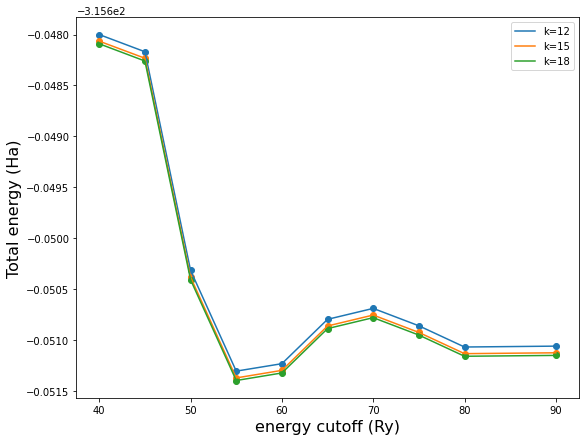

In [14]:
plt.figure(figsize=(9,7))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for k in kvalues:
    energy =study.fetch_results(id={'k':k},attribute='energy')
    plt.plot(ecut,energy,label='k=%s'%k)
    plt.scatter(ecut,energy)
plt.legend()

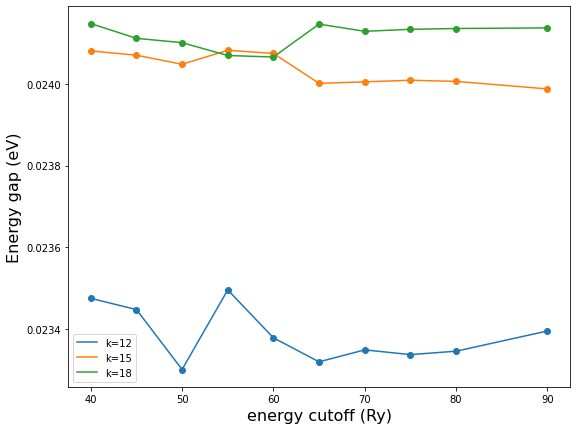

In [15]:
plt.figure(figsize=(9,7))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Energy gap (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap = [d.get_gap(verbose=False)['gap'] for d in data]
    plt.plot(ecut,gap,label='k=%s'%k)
    plt.scatter(ecut,gap)
plt.legend()

On the basis of these results we choose

In [8]:
ecut_conv = 50 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [18,18,1]

In [9]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)

### Calculation of the equilibrium lattice constants and buckling parameter

We determine the equiblrium values of the lattice constant and of the buckling parameter by minimizing
the GS energy

In [18]:
alat_range = 3 # alat percentage variation
alat_num = 7
delta_range = 3 # buckling percentage variation
delta_num = 7

alat_span = np.linspace(-alat_range/2,alat_range/2,alat_num)

delta_span = np.linspace(-delta_range/2,delta_range/2,delta_num)

alat_span, delta_span

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]))

In [19]:
study = D.Dataset(run_dir=run_dir,num_tasks=10)

for a_span in alat_span:
    for d_span in delta_span:
        a = alat*(1+a_span/100)
        d = delta*(1+d_span/100)
        A = np.array([0,0,d])
        B = np.array([0,1/np.sqrt(3),-d])
        idd = {'alat' : a_span, 'delta' : d_span}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_atomic_positions([['Ge',A],['Ge',B]],type='alat')
        inp.set_lattice(ibrav=4,celldm1=a,celldm3=c)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)
#study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 10 parallel tasks


In [20]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
Skip the run of alat_-1.5-delta_-1.5Skip the run ofSkip the run of
 alat_-1.5-delta_-1.0 
alat_-1.5-delta_-0.5Skip the run of
 alat_-1.5-delta_0.0Skip the run of
 alat_-1.5-delta_0.5
Skip the run ofSkip the run of  alat_-1.5-delta_1.0alat_-1.5-delta_1.5Skip the run of

 alat_-1.0-delta_-1.5
Skip the run of alat_-1.0-delta_-1.0
Skip the run of alat_-1.0-delta_-0.5
Task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ended 
 
Run the task [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
Skip the run of alat_-1.0-delta_0.0Skip the run of
 ala

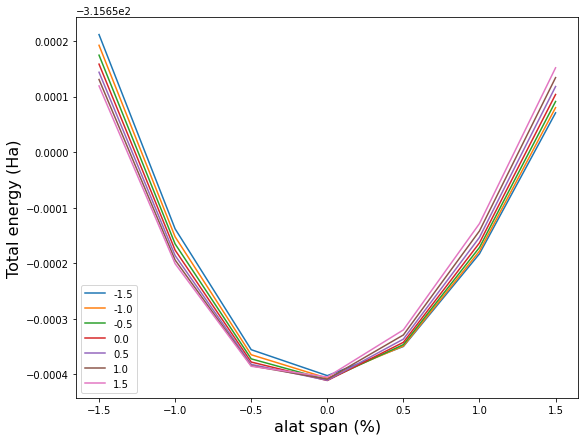

In [21]:
plt.figure(figsize=(9,7))
plt.xlabel('alat span (%)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for d_span in delta_span:
    energy =study.fetch_results(id={'delta':d_span})
    plt.plot(alat_span,energy,label=d_span)
plt.legend()

To find the optimal alat parameter we perform a quadratic fit of data (for delta=0)

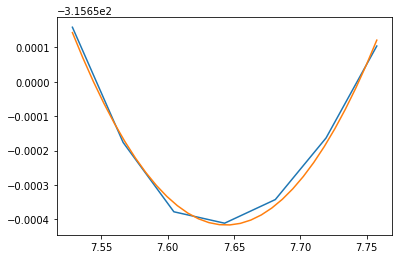

In [22]:
y =study.fetch_results(id={'delta':0.})
x = [alat*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [23]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

7.644145419128807

In substantial agreement with the value already provided in the input.

In the same way the optimal buckling is 

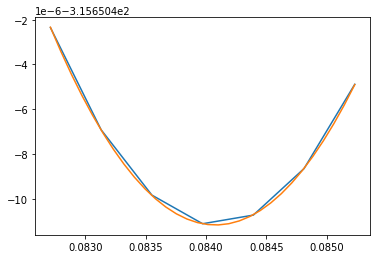

In [24]:
y =study.fetch_results(id={'alat':0.})
x = [delta*(1+a/100) for a in delta_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [25]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

0.08407897556000093

We perform a last scf calculation with the converged parameters

In [10]:
alat_conv = 7.6441
delta_conv = 0.0841

A = np.array([0,0,delta_conv])
B = np.array([0,1./np.sqrt(3),-delta_conv])

In [11]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
inp.set_atomic_positions([['Ge',A],['Ge',B]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c)
study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [14]:
study.runs

[{'label': 'Dataset',
  'run_dir': 'DFT_analysis-vac_4',
  'num_tasks': 1,
  'verbose': True,
  'input': {'control': {'calculation': "'scf'",
    'verbosity': "'high'",
    'prefix': "'gs_converged'",
    'outdir': "'./'",
    'pseudo_dir': "'../pseudos'"},
   'system': {'force_symmorphic': '.true.',
    'nbnd': 32,
    'lspinorb': '.true.',
    'noncolin': '.true.',
    'ntyp': '1',
    'nat': '2',
    'ibrav': 4,
    'celldm(1)': 7.6441,
    'celldm(3)': 4.0,
    'ecutwfc': 50},
   'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
   'ions': {},
   'cell': {},
   'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
   'atomic_positions': {'type': 'alat',
    'values': [['Ge', array([0.    , 0.    , 0.0841])],
     ['Ge', array([ 0.        ,  0.57735027, -0.0841    ])]]},
   'kpoints': {'type': 'automatic', 'values': ([18, 18, 1], [0.0, 0.0, 0.0])},
   'cell_parameters': {}},
  'name': 'gs_converged'}]

In [15]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
create the run_dir folder : 'DFT_analysis-vac_4'
run command: mpirun -np 32 pw.x -inp gs_converged.in > gs_converged.log
slurm submit:  cd DFT_analysis-vac_4 ; sbatch job_gs_converged.sh
computation gs_converged is running...
computation gs_converged ended
Task [0] ended 
 


In [16]:
results[0].get_gap()

Direct gap system
Gap : 0.024156505631320435 eV


{'gap': 0.024156505631320435,
 'direct_gap': 0.024156505631320435,
 'position_cbm': 36,
 'positon_vbm': 36}

The Gap (as given by the scf computation) with celldm3=6 is equal to 0.024154 eV.

In [26]:
kp = results[0].kpoints # cartesian coordinates in units of 2\pi/alat
kp[-1]

array([0.33333333, 0.57735027, 0.        ])

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [12]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [13]:
klist = Tools.build_kpath(G,Mp,Kp,G,numstep=60)
klist

[[0.0, 0.0, 0.0, 60],
 [0.0, 0.5773502691896258, 0.0, 60],
 [0.3333333333333333, 0.5773502691896258, 0.0, 60],
 [0.0, 0.0, 0.0, 0]]

In [14]:
inp.set_bands(32,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 32,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 7.6441,
  'celldm(3)': 4.0,
  'ecutwfc': 50},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ge', array([0.    , 0.    , 0.0841])],
   ['Ge', array([ 0.        ,  0.57735027, -0.0841    ])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 60],
   [0.0, 0.5773502691896258, 0.0, 60],
   [0.3333333333333333, 0.5773502691896258, 0.0, 60],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [16]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis-vac_4/gs_converged.save')

Skip the run of bands
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis-vac_4/bands.save already exists. Source_dir DFT_analysis-vac_4/gs_converged.save not copied


In [17]:
data = P.PwParser(results)

Parse file : /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis-vac_4/bands.save/data-file-schema.xml


In [18]:
data.get_gap()

Direct gap system
Gap : 0.02394132010610317 eV


{'gap': 0.02394132010610317,
 'direct_gap': 0.02394132010610317,
 'position_cbm': 120,
 'positon_vbm': 120}

The Gap (as given by the bands computation) with celldm3=6 is equal to 0.023927 eV.

In [19]:
kp = data.kpoints # cartesian coordinates in units of 2\pi/alat
kp[120]

array([0.33333333, 0.57735027, 0.        ])

Once that the computation is over we can create an instance of PwBands

In [20]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [21]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.577350265701805, 0.9106835999999988, 0.57735027])

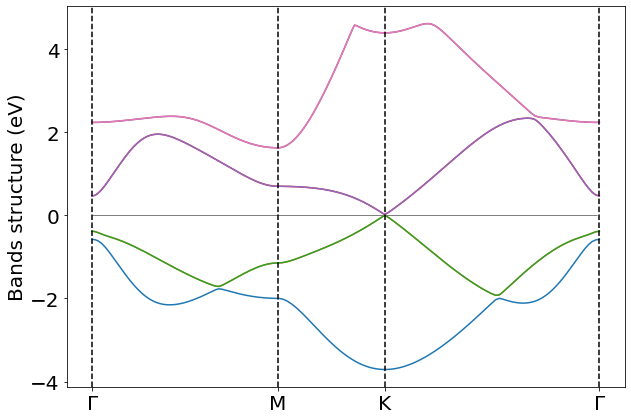

In [22]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 7))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(25,32)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

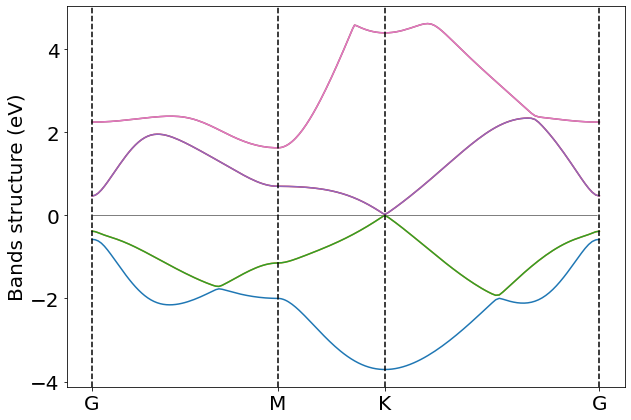

In [31]:
# plot for celldm3=6

label_size = 20

fig, ax = plt.subplots(figsize=(10, 7))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(25,32)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

We plot the bands near the Dirac cone

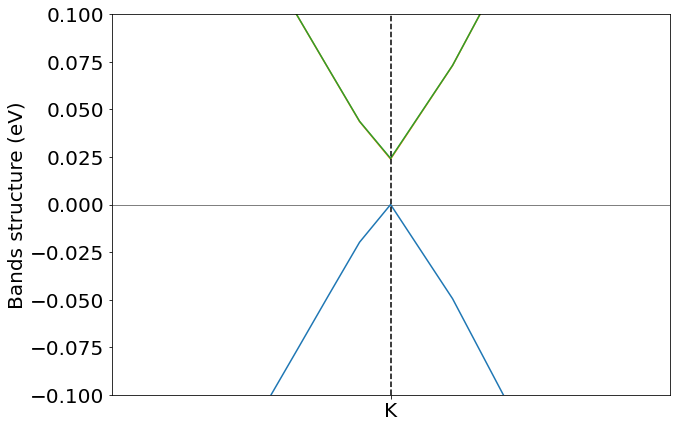

In [27]:
label_size = 20
K_pos = bands.get_high_sym_positions()[1][2]
dk = 0.05

fig, ax = plt.subplots(figsize=(10, 7))
bands.plot(plt,selection=[i for i in range(27,30)])
ax.set_xlim(K_pos-dk,K_pos+dk)
ax.set_ylim(-0.1,0.1)
ax.hlines(0.,0.,1.7,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

The gap is clearly visible.

## NSCF computations on regular grids

We perform NSCF computations on regular grids of various size to study the GW
convergence in function of the number of $k$-points.

We use an high number of empty bands that will be used in the GW analysis.

We write the coordinates of the high symmetry points

In [12]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [13]:
nbnds = 700 #40
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'gs_converged'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 700,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '1',
  'nat': '2',
  'ibrav': 4,
  'celldm(1)': 7.6441,
  'celldm(3)': 4.0,
  'ecutwfc': 50},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ge', array([0.    , 0.    , 0.0841])],
   ['Ge', array([ 0.        ,  0.57735027, -0.0841    ])]]},
 'kpoints': {'type': 'automatic', 'values': ([18, 18, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [14]:
kvalues = [30,60,81]

In [15]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis-vac_4/gs_converged.save')

Initialize a Dataset with 1 parallel tasks


In [16]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis-vac_4',
 'num_tasks': 1,
 'verbose': True,
 'input': {'control': {'calculation': "'nscf'",
   'verbosity': "'high'",
   'prefix': "'kpoints_30-nbnds_700'",
   'outdir': "'./'",
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'nbnd': 700,
   'lspinorb': '.true.',
   'noncolin': '.true.',
   'ntyp': '1',
   'nat': '2',
   'ibrav': 4,
   'celldm(1)': 7.6441,
   'celldm(3)': 4.0,
   'ecutwfc': 50},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'Ge': [72.64, 'Ge.rel-pbe-dn-kjpaw_psl.0.2.2.UPF']},
  'atomic_positions': {'type': 'alat',
   'values': [['Ge', array([0.    , 0.    , 0.0841])],
    ['Ge', array([ 0.        ,  0.57735027, -0.0841    ])]]},
  'kpoints': {'type': 'automatic', 'values': ([30, 30, 1], [0.0, 0.0, 0.0])},
  'cell_parameters': {}},
 'source_dir': 'DFT_analysis-vac_4/gs_converged.save',
 'name': 'kpoints_30-nbnds_700'}

In [17]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run performed starting from existing results
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/GERMANENE/DFT_analysis-vac_4/kpoints_30-nbnds_700.save already exists. Source_dir DFT_analysis-vac_4/gs_converged.save not copied
run command: mpirun -np 16 pw.x -inp kpoints_30-nbnds_700.in > kpoints_30-nbnds_700.log
slurm submit:  cd DFT_analysis-vac_4 ; sbatch job_kpoints_30-nbnds_700.sh
computation kpoints_30-nbnds_700 ended
Task [0] ended 
 


In [1]:
results[1].get_gap()

NameError: name 'results' is not defined

In [31]:
kp = results[2].kpoints # cartesian coordinates in units of 2\pi/alat
kp[-1] # the coordinates of the K point

array([0.33333333, 0.57735027, 0.        ])

Note that the gap in the nscf computation is slightly different w.r.t the gap computed in the scf which
includes some empty bands (23.9 eV vs 24.1 eV).

number of kpoints = 588


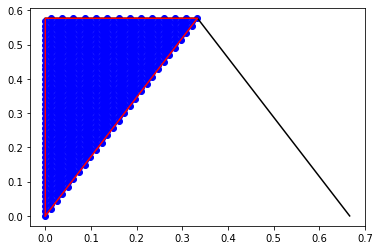

In [32]:
BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')

We observe the point $K'$ belongs to the grid for all the dimensions of the
sampling and that it is always the last point of the sampled list.